In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
%%time
df1= pd.read_csv("/content/sample_data/metadata",delimiter='\t',encoding='utf-8',names=['User-id','restaurant-id','rating','label','date'])


CPU times: user 217 ms, sys: 54.6 ms, total: 272 ms
Wall time: 331 ms


In [ ]:
df_review= pd.read_csv("/content/sample_data/reviewContent",delimiter='\t',names=['User-id','restaurant-id','date','review'],header=None)

In [ ]:
df_review.shape

(608458, 4)

In [ ]:
df_review_merge=pd.merge(df1,df_review,how='inner')

In [ ]:
df_review_merge.head()

,User-id,restaurant-id,rating,label,date,review
0,5044,0,1.0,-1,2014-11-16,"Drinks were bad, the hot chocolate was watered..."
1,5045,0,1.0,-1,2014-09-08,This was the worst experience I've ever had a ...
2,5046,0,3.0,-1,2013-10-06,This is located on the site of the old Spruce ...
3,5047,0,5.0,-1,2014-11-30,I enjoyed coffee and breakfast twice at Toast ...
4,5048,0,5.0,-1,2014-08-28,I love Toast! The food choices are fantastic -...


In [ ]:
df_review_merge['review'] = [i.replace("&amp;amp;", '').replace("\'",'') for i in df_review_merge['review']]

In [ ]:
df_review_merge.shape

(608458, 6)

In [ ]:
df_review_merge.label.value_counts()

 1    528019
-1     80439
Name: label, dtype: int64

In [ ]:
df_review_merge['label']=df_review_merge['label'].replace(-1,0)

In [ ]:
df_review_merge.head()

,User-id,restaurant-id,rating,label,date,review
0,5044,0,1.0,0,2014-11-16,"Drinks were bad, the hot chocolate was watered..."
1,5045,0,1.0,0,2014-09-08,This was the worst experience Ive ever had a c...
2,5046,0,3.0,0,2013-10-06,This is located on the site of the old Spruce ...
3,5047,0,5.0,0,2014-11-30,I enjoyed coffee and breakfast twice at Toast ...
4,5048,0,5.0,0,2014-08-28,I love Toast! The food choices are fantastic -...


In [ ]:
import string
import re
import nltk
nltk.download('all')
from nltk.tokenize import word_tokenize,sent_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

[nltk_data] Downloading collection 'all'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to /root/nltk_data...
[nltk_data]    |   Package abc is already up-to-date!
[nltk_data]    | Downloading package alpino to /root/nltk_data...
[nltk_data]    |   Package alpino is already up-to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Package averaged_perceptron_tagger is already up-
[nltk_data]    |       to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger_ru to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Package averaged_perceptron_tagger_ru is already
[nltk_data]    |       up-to-date!
[nltk_data]    | Downloading package basque_grammars to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Package basque_grammars is already up-to-date!
[nltk_data]    | Downloading package biocreative_ppi to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Pac

In [ ]:
#removing character references amp that is not useful for the model
df_review_merge['review'] = [i.replace("&amp;amp;", '').replace("\'",'') for i in df_review_merge['review']]

In [ ]:
import unicodedata

In [ ]:
%%time
def clean_text(txt):
    """""
    cleans the input text in the following steps
    1- replace contractions
    2- removing punctuation
    3- spliting into words
    4- removing stopwords
    5- removing leftover punctuations
    """""
    contraction_dict = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not", "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not", "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",  "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would", "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would", "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam", "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have", "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock", "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have", "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is", "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as", "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would", "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have", "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have", "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are", "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",  "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is", "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have", "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have", "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all", "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have","you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have", "you're": "you are", "you've": "you have"}
    def _get_contractions(contraction_dict):
        contraction_re = re.compile('(%s)' % '|'.join(contraction_dict.keys()))
        return contraction_dict, contraction_re

    def replace_contractions(text):
        contractions, contractions_re = _get_contractions(contraction_dict)
        def replace(match):
            return contractions[match.group(0)]
        return contractions_re.sub(replace, text)

    # replace contractions and convert to lowercase
    txt = txt.lower()
    #txt = replace_contractions(txt)
    
    #remove punctuations
    txt  = "".join([char for char in txt if char not in string.punctuation])
    txt = re.sub('[0-9]+', '', txt)
    txt= re.sub(r"([.,!?])", r" \1 ",txt)
    txt = re.sub(r"[^a-zA-Z.,!?]+", r" ", txt)
    txt = re.sub(r'[^\x00-\x7f]',r'', txt)#remove non ascii
    txt = unicodedata.normalize('NFKD', txt).encode('ascii', 'ignore').decode('utf-8', 'ignore')
    txt = re.sub(' +', ' ', txt).strip() #remove leading and trailing white spaces
    re.sub("(.)\\1{2,}", "\\1",txt) #removing duplicate values like youuuuu to you
  
    
    # split into words
    words = word_tokenize(txt)
    
    # remove stopwords
    #stop_words = set(stopwords.words('english'))
   # words = [w for w in words if not w in stop_words]
    
    # removing leftover punctuations
   # words = [word for word in words if word.isalpha()]

   # lemmatizer = nltk.stem.WordNetLemmatizer()
  #  def lemmatize_text(txt):
  #      return [lemmatizer.lemmatize(w) for w in words]

    cleaned_text = ' '.join(words)
    return cleaned_text
    
df_review_merge['review'] = df_review_merge['review'].apply(lambda txt: clean_text(txt))


CPU times: user 4min 51s, sys: 1.37 s, total: 4min 53s
Wall time: 4min 52s


In [ ]:
df_review_merge['review'].iloc[0]

'drinks were bad the hot chocolate was watered down and the latte had a burnt taste to it the food was also poor quality but the service was the worst part their cashier was very rude'

In [ ]:
df_review_merge.label.value_counts()

1    528019
0     80439
Name: label, dtype: int64

In [ ]:
sentences=df_review_merge.review.values
target=df_review_merge.label.values

In [ ]:
import tensorflow as tf

# Get the GPU device name.
device_name = tf.test.gpu_device_name()

# The device name should look like the following:
if device_name == '/device:GPU:0':
    print('Found GPU at: {}'.format(device_name))
else:
    raise SystemError('GPU device not found')

Found GPU at: /device:GPU:0


In [ ]:
import torch

# If there's a GPU available...
if torch.cuda.is_available():    

    # Tell PyTorch to use the GPU.    
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")
1.2

There are 1 GPU(s) available.
We will use the GPU: Tesla P100-PCIE-16GB


1.2

In [ ]:
!pip install transformers==3.0.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
#!pip install wandb

In [ ]:
!pip install Sentencepiece

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
#!pip install -q torch==1.4.0 -f https://download.pytorch.org/whl/cu101/torch_stable.html


In [ ]:
from transformers import RobertaConfig,AutoConfig

configuration = RobertaConfig.from_pretrained('roberta-base',output_attentions=False,output_hidden_states=False,num_labels=2)
configuration.hidden_dropout_prob = 0.2
configuration.attention_probs_dropout_prob = 0.1


In [ ]:
#Loading pre trained models
from transformers import (
    BertForSequenceClassification,
#     TFBertForSequenceClassification, 
                          BertTokenizer,
#                           TFRobertaForSequenceClassification,
                          RobertaForSequenceClassification,
                          RobertaTokenizer,
                          XLNetForSequenceClassification,
                          XLNetTokenizer,
                         AdamW)
roberta_model = RobertaForSequenceClassification.from_pretrained("roberta-base", # 12-layer, 768-hidden, 12-heads, 125M parameters RoBERTa using the BERT-base architecture
                                                                  # num_labels = 2, # The number of output labels--2 for binary classification.
                                                                                    # You can increase this for multi-class tasks.   
                                                                 #  output_attentions = False, # Whether the model returns attentions weights.
                                                                 # output_hidden_states = False, #, # Whether the model returns all hidden-states.
                                                                   config =configuration
                                                                )
roberta_tokenizer = RobertaTokenizer.from_pretrained("roberta-base")
roberta_model.cuda()



- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.2, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm

In [ ]:
# Print the original sentence.
print(' Original: ', sentences[0])

# Print the text split into tokens.
print('Tokenized RoBERT: ', roberta_tokenizer.tokenize(sentences[0]))

# Print the text mapped to token ids.
print('Token IDs RoBERTa: ', roberta_tokenizer.convert_tokens_to_ids(roberta_tokenizer.tokenize(sentences[0])))

 Original:  drinks were bad the hot chocolate was watered down and the latte had a burnt taste to it the food was also poor quality but the service was the worst part their cashier was very rude
Tokenized RoBERT:  ['dr', 'inks', 'Ġwere', 'Ġbad', 'Ġthe', 'Ġhot', 'Ġchocolate', 'Ġwas', 'Ġwatered', 'Ġdown', 'Ġand', 'Ġthe', 'Ġlat', 'te', 'Ġhad', 'Ġa', 'Ġburnt', 'Ġtaste', 'Ġto', 'Ġit', 'Ġthe', 'Ġfood', 'Ġwas', 'Ġalso', 'Ġpoor', 'Ġquality', 'Ġbut', 'Ġthe', 'Ġservice', 'Ġwas', 'Ġthe', 'Ġworst', 'Ġpart', 'Ġtheir', 'Ġcash', 'ier', 'Ġwas', 'Ġvery', 'Ġrude']
Token IDs RoBERTa:  [10232, 12935, 58, 1099, 5, 2131, 7548, 21, 36408, 159, 8, 5, 16619, 859, 56, 10, 18698, 5840, 7, 24, 5, 689, 21, 67, 2129, 1318, 53, 5, 544, 21, 5, 2373, 233, 49, 1055, 906, 21, 182, 21820]


In [ ]:
sequence = """Will Your Hometown Be Taking In Obama’s Refugees? Here’s The List Of Cities Where They’re Being Transplanted 🏙️"""
roberta_tokenized_sequence = roberta_tokenizer.tokenize(sequence)
print("RoBERTa:", roberta_tokenized_sequence)

RoBERTa: ['Will', 'ĠYour', 'ĠH', 'ometown', 'ĠBe', 'ĠTaking', 'ĠIn', 'ĠObama', 'âĢ', 'Ļ', 's', 'ĠRefugees', '?', 'ĠHere', 'âĢ', 'Ļ', 's', 'ĠThe', 'ĠList', 'ĠOf', 'ĠCities', 'ĠWhere', 'ĠThey', 'âĢ', 'Ļ', 're', 'ĠBeing', 'ĠTrans', 'pl', 'anted', 'ĠðŁ', 'ı', 'Ļ', 'ï¸ı']


In [ ]:
token_lens = []

for txt in sentences:
    tokens = roberta_tokenizer.encode(txt,truncation=True, max_length=512)
    token_lens.append(len(tokens))

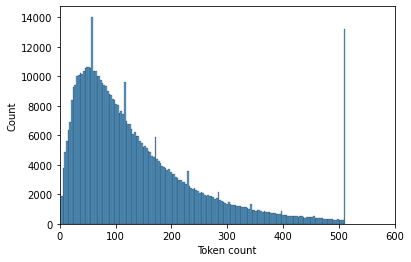

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.histplot(token_lens)
plt.xlim([0, 600]);
plt.xlabel('Token count');

In [ ]:
# Tokenize all of the sentences and map the tokens to thier word IDs.
roberta_input_ids = []
roberta_attention_masks = []

# For every sentence...
for sent in sentences:
    # `encode_plus` will:
    #   (1) Tokenize the sentence.
    #   (2) Prepend the `[CLS]` token to the start.
    #   (3) Append the `[SEP]` token to the end.
    #   (4) Map tokens to their IDs.
    #   (5) Pad or truncate the sentence to `max_length`
    #   (6) Create attention masks for [PAD] tokens.
    roberta_encoded_dict = roberta_tokenizer.encode_plus(
                        sent,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        max_length = 256,           # Pad & truncate all sentences.
                        pad_to_max_length = True,
                        return_attention_mask = True,   # Construct attn. masks.
                        return_tensors = 'pt',
                        truncation=True    # Return pytorch tensors.
                   )
    
    # Add the encoded sentence to the list.    
    roberta_input_ids.append(roberta_encoded_dict['input_ids'])
    
    # And its attention mask (simply differentiates padding from non-padding).
    roberta_attention_masks.append(roberta_encoded_dict['attention_mask'])

# Convert the lists into tensors.
roberta_input_ids = torch.cat(roberta_input_ids, dim=0)
roberta_attention_masks = torch.cat(roberta_attention_masks, dim=0)
labels = torch.tensor(df_review_merge.label.values)

# Print sentence 0, now as a list of IDs.
print('Original: ', sentences[0])
print('Token IDs:', roberta_input_ids[0])
print('labels:', labels)

Original:  drinks were bad the hot chocolate was watered down and the latte had a burnt taste to it the food was also poor quality but the service was the worst part their cashier was very rude
Token IDs: tensor([    0, 10232, 12935,    58,  1099,     5,  2131,  7548,    21, 36408,
          159,     8,     5, 16619,   859,    56,    10, 18698,  5840,     7,
           24,     5,   689,    21,    67,  2129,  1318,    53,     5,   544,
           21,     5,  2373,   233,    49,  1055,   906,    21,   182, 21820,
            2,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1, 

In [ ]:
from torch.utils.data import TensorDataset, random_split

# Combine the training inputs into a TensorDataset.
dataset = TensorDataset(roberta_input_ids, roberta_attention_masks, labels)

# Create a 80-20 train-validation split.

# Calculate the number of samples to include in each set.
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size

# Divide the dataset by randomly selecting samples.
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

print('{:>5,} training samples'.format(train_size))
print('{:>5,} validation samples'.format(val_size))

486,766 training samples
121,692 validation samples


In [ ]:
len(train_dataset)

486766

In [ ]:
import collections as c
train_classes = [df_review_merge.label[i] for i in train_dataset.indices]
c.Counter(train_classes)

Counter({1: 422485, 0: 64281})

In [ ]:
#Using weighted random sampler for class imbalance
import numpy as np 

y_train_indices = train_dataset.indices

y_train = [target[i] for i in y_train_indices]

class_sample_count = np.array(
    [len(np.where(y_train == t)[0]) for t in np.unique(y_train)])
print(class_sample_count)
weight = 1. / (class_sample_count)
print(weight)
samples_weight = np.array([weight[t] for t in y_train])
samples_weight = torch.from_numpy(samples_weight)
print(samples_weight)
sampler = torch.utils.data.sampler.WeightedRandomSampler(samples_weight.type('torch.DoubleTensor'), len(samples_weight))
print(next(iter(sampler)))
print(sampler)

[ 64281 422485]
[1.55566964e-05 2.36694794e-06]
tensor([2.3669e-06, 2.3669e-06, 2.3669e-06,  ..., 2.3669e-06, 2.3669e-06,
        2.3669e-06], dtype=torch.float64)
227551


In [ ]:
labels_unique,counts=np.unique(y_train,return_counts=True)
counts
class_weights=[sum(counts)/c for c in counts]
class_weights
example_weights=[class_weights[e] for e in y_train]
#len(torch.example_weights)
#sampler = torch.utils.data.sampler.WeightedRandomSampler(example_weights.type('torch.DoubleTensor'), len(example_weights))
#sampler

In [ ]:
np.unique(df_review_merge.label)

array([0, 1])

In [ ]:
#Run if we are using weighted random sampler
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

# The DataLoader needs to know our batch size for training, so we specify it 
# here. For fine-tuning BERT on a specific task, the authors recommend a batch 
# size of 16 or 32 or 64.
batch_size = 64
gradient_accumulations=10

# Create the DataLoaders for our training and validation sets.
# We'll take training samples in random order. 
train_dataloader = DataLoader(
            train_dataset,  # The training samples.
            sampler = sampler, # Select batches randomly
            batch_size = batch_size, # Trains with this batch size.
            num_workers=2,
            pin_memory = True
        )

# For validation the order doesn't matter, so we'll just read them sequentially.
validation_dataloader = DataLoader(
            val_dataset, # The validation samples.
            sampler = SequentialSampler(val_dataset), # Pull out batches sequentially.
            batch_size = batch_size, # Evaluate with this batch size.
            num_workers =2,
            pin_memory = True
        )

In [ ]:
#Run if we are using only random sampler for train data 
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

# The DataLoader needs to know our batch size for training, so we specify it 
# here. For fine-tuning BERT on a specific task, the authors recommend a batch 
# size of 16 or 32 or 64.
batch_size = 64
gradient_accumulations=10

# Create the DataLoaders for our training and validation sets.
# We'll take training samples in random order. 
train_dataloader = DataLoader(
            train_dataset,  # The training samples.
            sampler = RandomSampler(train_dataset), # Select batches randomly
            batch_size = batch_size, # Trains with this batch size.
            num_workers=2,
            pin_memory = True
        )

# For validation the order doesn't matter, so we'll just read them sequentially.
validation_dataloader = DataLoader(
            val_dataset, # The validation samples.
            sampler = SequentialSampler(val_dataset), # Pull out batches sequentially.
            batch_size = batch_size, # Evaluate with this batch size.
            num_workers =2,
            pin_memory = True
        )

In [ ]:
#Testing the label counts in training data after applying weighted random sampler
import collections as c
train_labels = next(iter(train_dataloader))
#print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels[0].values}")
#img = train_features[0].squeeze()
label = train_labels[2]
torch.bincount(label)
#print(label)


Labels batch shape: <built-in method values of Tensor object at 0x7f2f826bc290>


tensor([33, 31])

In [ ]:
len(train_dataloader)

7606

In [ ]:
#2nd method using pos weight for imbalance subsitute in loss function
y_train=torch.Tensor(y_train)
num_positives = torch.sum(y_train, dim=0)
print(num_positives)
num_negatives = len(train_dataset) - num_positives
print(num_negatives)
pos_weight  = num_negatives / num_positives
pos_weight



tensor(422485.)
tensor(64281.)


tensor(0.1521)

In [ ]:

# Get all of the model's parameters as a list of tuples.
params = list(roberta_model.named_parameters())

print('The Roberta model has {:} different named parameters.\n'.format(len(params)))

print('==== Embedding Layer ====\n')

for p in params[0:5]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== First Transformer ====\n')

for p in params[5:21]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== Output Layer ====\n')

for p in params[-4:]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

The Roberta model has 203 different named parameters.

==== Embedding Layer ====

roberta.embeddings.word_embeddings.weight               (50265, 768)
roberta.embeddings.position_embeddings.weight             (514, 768)
roberta.embeddings.token_type_embeddings.weight             (1, 768)
roberta.embeddings.LayerNorm.weight                           (768,)
roberta.embeddings.LayerNorm.bias                             (768,)

==== First Transformer ====

roberta.encoder.layer.0.attention.self.query.weight       (768, 768)
roberta.encoder.layer.0.attention.self.query.bias             (768,)
roberta.encoder.layer.0.attention.self.key.weight         (768, 768)
roberta.encoder.layer.0.attention.self.key.bias               (768,)
roberta.encoder.layer.0.attention.self.value.weight       (768, 768)
roberta.encoder.layer.0.attention.self.value.bias             (768,)
roberta.encoder.layer.0.attention.output.dense.weight     (768, 768)
roberta.encoder.layer.0.attention.output.dense.bias         

In [ ]:
# Note: AdamW is a class from the huggingface library (as opposed to pytorch) 
# I believe the 'W' stands for 'Weight Decay fix"
no_decay = ['bias', 'LayerNorm.weight']
optimizer_grouped_parameters = [
    {'params': [p for n, p in roberta_model.named_parameters() if not any(nd in n for nd in no_decay)], 'weight_decay': 0.01},
    {'params': [p for n, p in roberta_model.named_parameters() if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}
]
optimizer = AdamW(optimizer_grouped_parameters, lr=3e-5, eps = 1e-8)

In [ ]:
from transformers import get_linear_schedule_with_warmup

# Number of training epochs. The BERT authors recommend between 2 and 4. 
# We chose to run for 4, but we'll see later that this may be over-fitting the
# training data.
epochs = 3

# Total number of training steps is [number of batches] x [number of epochs]. 
# (Note that this is not the same as the number of training samples).
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)

In [ ]:
import numpy as np

# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [ ]:
from torch.cuda.amp import GradScaler, autocast

In [ ]:
import time
import datetime

def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

In [ ]:
#Loss function with weight
def loss_fn1(outputs, targets):
    return torch.nn.BCEWithLogitsLoss(pos_weight=pos_weight)(outputs, targets.float())

In [ ]:
def loss_fn(outputs, targets):
    return torch.nn.BCEWithLogitsLoss()(outputs, targets.float())


======== Epoch 1 / 3 ========
Training...
  Batch    40  of  7,606.    Elapsed: 0:00:58.
  Batch    80  of  7,606.    Elapsed: 0:01:55.
  Batch   120  of  7,606.    Elapsed: 0:02:52.
  Batch   160  of  7,606.    Elapsed: 0:03:49.
  Batch   200  of  7,606.    Elapsed: 0:04:46.
  Batch   240  of  7,606.    Elapsed: 0:05:43.
  Batch   280  of  7,606.    Elapsed: 0:06:40.
  Batch   320  of  7,606.    Elapsed: 0:07:37.
  Batch   360  of  7,606.    Elapsed: 0:08:34.
  Batch   400  of  7,606.    Elapsed: 0:09:31.
  Batch   440  of  7,606.    Elapsed: 0:10:28.
  Batch   480  of  7,606.    Elapsed: 0:11:25.
  Batch   520  of  7,606.    Elapsed: 0:12:22.
  Batch   560  of  7,606.    Elapsed: 0:13:19.
  Batch   600  of  7,606.    Elapsed: 0:14:16.
  Batch   640  of  7,606.    Elapsed: 0:15:13.
  Batch   680  of  7,606.    Elapsed: 0:16:10.
  Batch   720  of  7,606.    Elapsed: 0:17:07.
  Batch   760  of  7,606.    Elapsed: 0:18:04.
  Batch   800  of  7,606.    Elapsed: 0:19:01.
  Batch   840  of

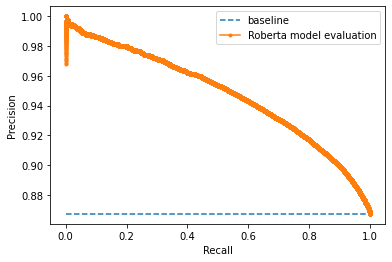

  Validation Loss: 0.70
  Validation took: 0:15:47

======== Epoch 2 / 3 ========
Training...
  Batch    40  of  7,606.    Elapsed: 0:00:57.
  Batch    80  of  7,606.    Elapsed: 0:01:54.
  Batch   120  of  7,606.    Elapsed: 0:02:51.
  Batch   160  of  7,606.    Elapsed: 0:03:48.
  Batch   200  of  7,606.    Elapsed: 0:04:45.
  Batch   240  of  7,606.    Elapsed: 0:05:43.
  Batch   280  of  7,606.    Elapsed: 0:06:40.
  Batch   320  of  7,606.    Elapsed: 0:07:37.
  Batch   360  of  7,606.    Elapsed: 0:08:34.
  Batch   400  of  7,606.    Elapsed: 0:09:31.
  Batch   440  of  7,606.    Elapsed: 0:10:28.
  Batch   480  of  7,606.    Elapsed: 0:11:25.
  Batch   520  of  7,606.    Elapsed: 0:12:22.
  Batch   560  of  7,606.    Elapsed: 0:13:19.
  Batch   600  of  7,606.    Elapsed: 0:14:16.
  Batch   640  of  7,606.    Elapsed: 0:15:13.
  Batch   680  of  7,606.    Elapsed: 0:16:10.
  Batch   720  of  7,606.    Elapsed: 0:17:07.
  Batch   760  of  7,606.    Elapsed: 0:18:04.
  Batch   800

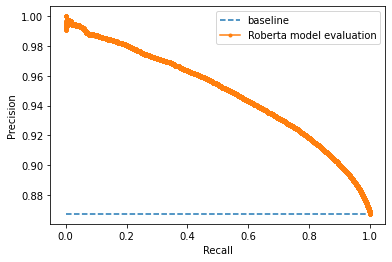

  Validation Loss: 0.66
  Validation took: 0:15:46

======== Epoch 3 / 3 ========
Training...
  Batch    40  of  7,606.    Elapsed: 0:00:57.
  Batch    80  of  7,606.    Elapsed: 0:01:54.
  Batch   120  of  7,606.    Elapsed: 0:02:51.
  Batch   160  of  7,606.    Elapsed: 0:03:48.
  Batch   200  of  7,606.    Elapsed: 0:04:45.
  Batch   240  of  7,606.    Elapsed: 0:05:42.
  Batch   280  of  7,606.    Elapsed: 0:06:40.
  Batch   320  of  7,606.    Elapsed: 0:07:37.
  Batch   360  of  7,606.    Elapsed: 0:08:34.
  Batch   400  of  7,606.    Elapsed: 0:09:31.
  Batch   440  of  7,606.    Elapsed: 0:10:28.
  Batch   480  of  7,606.    Elapsed: 0:11:25.
  Batch   520  of  7,606.    Elapsed: 0:12:22.
  Batch   560  of  7,606.    Elapsed: 0:13:19.
  Batch   600  of  7,606.    Elapsed: 0:14:16.
  Batch   640  of  7,606.    Elapsed: 0:15:13.
  Batch   680  of  7,606.    Elapsed: 0:16:10.
  Batch   720  of  7,606.    Elapsed: 0:17:07.
  Batch   760  of  7,606.    Elapsed: 0:18:04.
  Batch   800

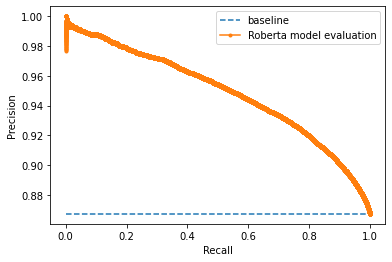

  Validation Loss: 0.68
  Validation took: 0:15:48

Training complete!
Total training took 9:49:32 (h:mm:ss)


In [ ]:
#using weighted random sampler
from sklearn.metrics import classification_report,auc,confusion_matrix,f1_score,precision_recall_curve,plot_precision_recall_curve,matthews_corrcoef
import random
# This training code is based on the `run_glue.py` script here:
# https://github.com/huggingface/transformers/blob/5bfcd0485ece086ebcbed2d008813037968a9e58/examples/run_glue.py#L128

# Set the seed value all over the place to make this reproducible.
seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)
scaler = GradScaler()
criterion = torch.nn.BCEWithLogitsLoss()
# We'll store a number of quantities such as training and validation loss, 
# validation accuracy, and timings.
training_stats = []

# Measure the total training time for the whole run.
total_t0 = time.time()

# For each epoch...
for epoch_i in range(0, epochs):
    
    # ========================================
    #               Training
    # ========================================
    
    # Perform one full pass over the training set.

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    # Measure how long the training epoch takes.
    t0 = time.time()

    # Reset the total loss for this epoch.
    total_train_loss = 0

    # Put the model into training mode. Don't be mislead--the call to 
    # `train` just changes the *mode*, it doesn't *perform* the training.
    # `dropout` and `batchnorm` layers behave differently during training
    # vs. test (source: https://stackoverflow.com/questions/51433378/what-does-model-train-do-in-pytorch)
    roberta_model.train()

    # For each batch of training data...
    for step, batch in enumerate(train_dataloader):

        # Progress update every 40 batches.
        if step % 40 == 0 and not step == 0:
            # Calculate elapsed time in minutes.
            elapsed = format_time(time.time() - t0)
            
            # Report progress.
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        # Unpack this training batch from our dataloader. 
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using the 
        # `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        # Always clear any previously calculated gradients before performing a
        # backward pass. PyTorch doesn't do this automatically because 
        # accumulating the gradients is "convenient while training RNNs". 
        # (source: https://stackoverflow.com/questions/48001598/why-do-we-need-to-call-zero-grad-in-pytorch)
        roberta_model.zero_grad()        

        # Perform a forward pass (evaluate the model on this training batch).
        # The documentation for this `model` function is here: 
        # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
        # It returns different numbers of parameters depending on what arguments
        # arge given and what flags are set. For our useage here, it returns
        # the loss (because we provided labels) and the "logits"--the model
        # outputs prior to activation.
        with autocast():
            loss, logits = roberta_model(b_input_ids, 
                             token_type_ids=None, 
                             attention_mask=b_input_mask, 
                             labels=b_labels)
            b_labels1=torch.nn.functional.one_hot(b_labels, num_classes=2)
            #Calculating weights
            #positive=torch.sum(b_labels1, dim=0)
           # negative=len(b_labels1)-positive
            #negative
            #pos_weight  = positive / negative
            #criterion.pos_weight = pos_weight
            loss1 = loss_fn(logits,b_labels1).to(device)
           # print("loss:",loss1)
            loss1 = loss1 / gradient_accumulations

        # Accumulate the training loss over all of the batches so that we can
        # calculate the average loss at the end. `loss` is a Tensor containing a
        # single value; the `.item()` function just returns the Python value 
        # from the tensor.
        total_train_loss += loss1.item()

        # Perform a backward pass to calculate the gradients.
        scaler.scale(loss1).backward()

        # Clip the norm of the gradients to 1.0.
        # This is to help prevent the "exploding gradients" problem.
       # torch.nn.utils.clip_grad_norm_(model.parameters(),max_norm*scaler.get_scale())

        # Update parameters and take a step using the computed gradient.
        # The optimizer dictates the "update rule"--how the parameters are
        # modified based on their gradients, the learning rate, etc.
        if ((step + 1) % gradient_accumulations == 0):
             scaler.step(optimizer)
       # Updates the scale for next iteration.
             scaler.update()
        # Update the learning rate.
             scheduler.step()       
             optimizer.zero_grad()
            # roberta_model.zero_grad()

    # Calculate the average loss over all of the batches.
    avg_train_loss = total_train_loss / len(train_dataloader)            
    
    # Measure how long this epoch took.
    training_time = format_time(time.time() - t0)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epcoh took: {:}".format(training_time))
        
    # ========================================
    #               Validation
    # ========================================
    # After the completion of each training epoch, measure our performance on
    # our validation set.

    print("")
    print("Running Validation...")

    t0 = time.time()

    # Put the model in evaluation mode--the dropout layers behave differently
    # during evaluation.
    roberta_model.eval()

    # Tracking variables 
    total_eval_accuracy = 0
    total_eval_loss = 0
    nb_eval_steps = 0
    total_f1_score =0
    predlist =[]
    lbllist =[]
    total_logits=[]

    # Evaluate data for one epoch
    for batch in validation_dataloader:
        
        # Unpack this training batch from our dataloader. 
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using 
        # the `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        
        # Tell pytorch not to bother with constructing the compute graph during
        # the forward pass, since this is only needed for backprop (training).
        with torch.no_grad():        

            # Forward pass, calculate logit predictions.
            # token_type_ids is the same as the "segment ids", which 
            # differentiates sentence 1 and 2 in 2-sentence tasks.
            # The documentation for this `model` function is here: 
            # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
            # Get the "logits" output by the model. The "logits" are the output
            # values prior to applying an activation function like the softmax.
            (loss, logits) = roberta_model(b_input_ids, 
                                   token_type_ids=None, 
                                   attention_mask=b_input_mask,
                                   labels=b_labels)
            #Converting the labels to one hot to sync with same shape as logits
            b_labels1=torch.nn.functional.one_hot(b_labels, num_classes=2)
            loss1 = loss_fn(logits, b_labels1)
       # print("loss1:",loss1)
            
        # Accumulate the validation loss.
        total_eval_loss += loss1.item()

         #Converting for predictions by applying sigmoid to logits
        pred_logits_sigmoid=torch.sigmoid(logits)
        y_pred=torch.round(pred_logits_sigmoid)
        
        # Move logits and labels to CPU
        logits_pred = y_pred.detach().cpu().numpy()
        label_ids1 = b_labels.to('cpu').numpy()
        logits=logits.detach().cpu().numpy()
        #For confusion matrix and classification report to work we need same dimensions.
        label_ids = b_labels1.to('cpu').numpy()
        pred_logits_sigmoid=pred_logits_sigmoid.detach().cpu().numpy()
     
        # Calculate the accuracy for this batch of test sentences, and
        # accumulate it over all batches.
        total_eval_accuracy += flat_accuracy(logits, label_ids1)

         #print(predictions)
       # predictions=np.argmax(logits_pred, axis=1)
        predictions =np.argmax(logits_pred,axis=1)
        y_test=np.argmax(label_ids,axis=1)
        predlist.extend(predictions)
        lbllist.extend(y_test)
        #Accumulating the sigmoid positive logits for precision recall curve
        total_logits.extend(pred_logits_sigmoid[:,1])
        #total_logits.extend(pred_logits_sigmoid)
        total_f1_score += f1_score(predlist,lbllist, average = 'macro')
        

    # Report the final accuracy for this validation run.
    avg_val_accuracy = total_eval_accuracy / len(validation_dataloader)
    print("  Accuracy: {0:.2f}".format(avg_val_accuracy))

    #f1 score

    avg_f1_score =total_f1_score/len(validation_dataloader)
    print("  F1 score: {0:.2f}".format(avg_f1_score))

     #classification report
    print(classification_report(lbllist, predlist))  

    #confusion matrix
    cm = confusion_matrix(lbllist,predlist)
    # constant for classes
    print(cm)
    #mcc score
    print("Mathews Correlation coefficient score for this epoch is :",round(matthews_corrcoef(lbllist, predlist),2))
    #Precision recall curve plot
    lr_precision, lr_recall, thresholds = precision_recall_curve(lbllist,total_logits)
    lr_f1, lr_auc = f1_score( lbllist,predlist), auc(lr_recall, lr_precision)
    print('Model validation score: f1=%.3f auc=%.3f' % (lr_f1, lr_auc))
    baseline = lbllist.count(1) / len(lbllist)
    plt.plot([0, 1], [baseline, baseline], linestyle='--', label='baseline')
    plt.plot(lr_recall, lr_precision, marker='.', label='Roberta model evaluation')
    # axis labels
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    # show the legend
    plt.legend()
    # show the plot
    plt.show()

    # Calculate the average loss over all of the batches.
    avg_val_loss = total_eval_loss / len(validation_dataloader)
    
    # Measure how long the validation run took.
    validation_time = format_time(time.time() - t0)
    
    print("  Validation Loss: {0:.2f}".format(avg_val_loss))
    print("  Validation took: {:}".format(validation_time))

    # Record all statistics from this epoch.
    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Valid. Accur.': avg_val_accuracy,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )

print("")
print("Training complete!")

print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))

In [ ]:
len(total_logits)

121692

In [ ]:
print("Mathews Correlation coefficient score for this epoch is :",round(matthews_corrcoef(lbllist, predlist),2))


======== Epoch 1 / 3 ========
Training...
  Batch    40  of  7,606.    Elapsed: 0:00:57.
  Batch    80  of  7,606.    Elapsed: 0:01:54.
  Batch   120  of  7,606.    Elapsed: 0:02:51.
  Batch   160  of  7,606.    Elapsed: 0:03:48.
  Batch   200  of  7,606.    Elapsed: 0:04:46.
  Batch   240  of  7,606.    Elapsed: 0:05:43.
  Batch   280  of  7,606.    Elapsed: 0:06:40.
  Batch   320  of  7,606.    Elapsed: 0:07:37.
  Batch   360  of  7,606.    Elapsed: 0:08:34.
  Batch   400  of  7,606.    Elapsed: 0:09:31.
  Batch   440  of  7,606.    Elapsed: 0:10:28.
  Batch   480  of  7,606.    Elapsed: 0:11:25.
  Batch   520  of  7,606.    Elapsed: 0:12:22.
  Batch   560  of  7,606.    Elapsed: 0:13:19.
  Batch   600  of  7,606.    Elapsed: 0:14:16.
  Batch   640  of  7,606.    Elapsed: 0:15:13.
  Batch   680  of  7,606.    Elapsed: 0:16:10.
  Batch   720  of  7,606.    Elapsed: 0:17:07.
  Batch   760  of  7,606.    Elapsed: 0:18:04.
  Batch   800  of  7,606.    Elapsed: 0:19:01.
  Batch   840  of

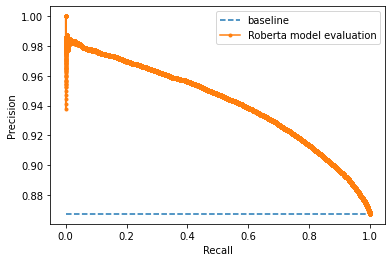

  Validation Loss: 0.53
  Validation took: 0:14:18

======== Epoch 2 / 3 ========
Training...
  Batch    40  of  7,606.    Elapsed: 0:00:57.
  Batch    80  of  7,606.    Elapsed: 0:01:54.
  Batch   120  of  7,606.    Elapsed: 0:02:51.
  Batch   160  of  7,606.    Elapsed: 0:03:48.
  Batch   200  of  7,606.    Elapsed: 0:04:45.
  Batch   240  of  7,606.    Elapsed: 0:05:43.
  Batch   280  of  7,606.    Elapsed: 0:06:40.
  Batch   320  of  7,606.    Elapsed: 0:07:37.
  Batch   360  of  7,606.    Elapsed: 0:08:34.
  Batch   400  of  7,606.    Elapsed: 0:09:31.
  Batch   440  of  7,606.    Elapsed: 0:10:28.
  Batch   480  of  7,606.    Elapsed: 0:11:25.
  Batch   520  of  7,606.    Elapsed: 0:12:22.
  Batch   560  of  7,606.    Elapsed: 0:13:19.
  Batch   600  of  7,606.    Elapsed: 0:14:16.
  Batch   640  of  7,606.    Elapsed: 0:15:13.
  Batch   680  of  7,606.    Elapsed: 0:16:10.
  Batch   720  of  7,606.    Elapsed: 0:17:07.
  Batch   760  of  7,606.    Elapsed: 0:18:04.
  Batch   800

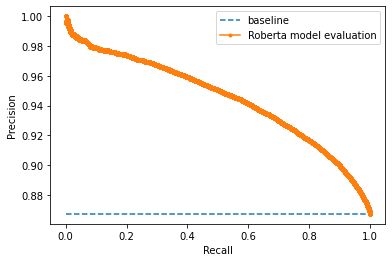

  Validation Loss: 0.56
  Validation took: 0:14:18

======== Epoch 3 / 3 ========
Training...
  Batch    40  of  7,606.    Elapsed: 0:00:57.
  Batch    80  of  7,606.    Elapsed: 0:01:54.
  Batch   120  of  7,606.    Elapsed: 0:02:51.
  Batch   160  of  7,606.    Elapsed: 0:03:48.
  Batch   200  of  7,606.    Elapsed: 0:04:45.
  Batch   240  of  7,606.    Elapsed: 0:05:43.
  Batch   280  of  7,606.    Elapsed: 0:06:40.
  Batch   320  of  7,606.    Elapsed: 0:07:37.
  Batch   360  of  7,606.    Elapsed: 0:08:34.
  Batch   400  of  7,606.    Elapsed: 0:09:31.
  Batch   440  of  7,606.    Elapsed: 0:10:28.
  Batch   480  of  7,606.    Elapsed: 0:11:25.
  Batch   520  of  7,606.    Elapsed: 0:12:22.
  Batch   560  of  7,606.    Elapsed: 0:13:19.
  Batch   600  of  7,606.    Elapsed: 0:14:16.
  Batch   640  of  7,606.    Elapsed: 0:15:13.
  Batch   680  of  7,606.    Elapsed: 0:16:10.
  Batch   720  of  7,606.    Elapsed: 0:17:07.
  Batch   760  of  7,606.    Elapsed: 0:18:04.
  Batch   800

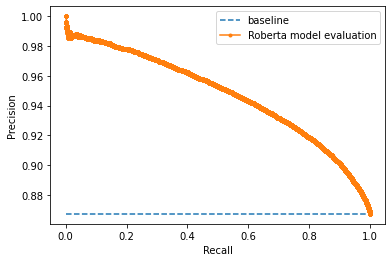

  Validation Loss: 0.54
  Validation took: 0:14:18

Training complete!
Total training took 9:45:18 (h:mm:ss)


In [ ]:
 #Using pos weight of loss_fn
from sklearn.metrics import classification_report,confusion_matrix,f1_score,auc,precision_recall_curve,plot_precision_recall_curve,matthews_corrcoef
import random
# This training code is based on the `run_glue.py` script here:
# https://github.com/huggingface/transformers/blob/5bfcd0485ece086ebcbed2d008813037968a9e58/examples/run_glue.py#L128

# Set the seed value all over the place to make this reproducible.
seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)
scaler = GradScaler()
criterion = torch.nn.BCEWithLogitsLoss()
# We'll store a number of quantities such as training and validation loss, 
# validation accuracy, and timings.
training_stats = []

# Measure the total training time for the whole run.
total_t0 = time.time()

# For each epoch...
for epoch_i in range(0, epochs):
    
    # ========================================
    #               Training
    # ========================================
    
    # Perform one full pass over the training set.

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    # Measure how long the training epoch takes.
    t0 = time.time()

    # Reset the total loss for this epoch.
    total_train_loss = 0

    # Put the model into training mode. Don't be mislead--the call to 
    # `train` just changes the *mode*, it doesn't *perform* the training.
    # `dropout` and `batchnorm` layers behave differently during training
    # vs. test (source: https://stackoverflow.com/questions/51433378/what-does-model-train-do-in-pytorch)
    roberta_model.train()

    # For each batch of training data...
    for step, batch in enumerate(train_dataloader):

        # Progress update every 40 batches.
        if step % 40 == 0 and not step == 0:
            # Calculate elapsed time in minutes.
            elapsed = format_time(time.time() - t0)
            
            # Report progress.
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        # Unpack this training batch from our dataloader. 
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using the 
        # `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        # Always clear any previously calculated gradients before performing a
        # backward pass. PyTorch doesn't do this automatically because 
        # accumulating the gradients is "convenient while training RNNs". 
        # (source: https://stackoverflow.com/questions/48001598/why-do-we-need-to-call-zero-grad-in-pytorch)
        roberta_model.zero_grad()        

        # Perform a forward pass (evaluate the model on this training batch).
        # The documentation for this `model` function is here: 
        # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
        # It returns different numbers of parameters depending on what arguments
        # arge given and what flags are set. For our useage here, it returns
        # the loss (because we provided labels) and the "logits"--the model
        # outputs prior to activation.
        with autocast():
            loss, logits = roberta_model(b_input_ids, 
                             token_type_ids=None, 
                             attention_mask=b_input_mask, 
                             labels=b_labels)
            b_labels1=torch.nn.functional.one_hot(b_labels, num_classes=2)
            #Calculating weights
            #positive=torch.sum(b_labels1, dim=0)
           # negative=len(b_labels1)-positive
            #negative
            #pos_weight  = positive / negative
            #criterion.pos_weight = pos_weight
            loss1 = loss_fn1(logits,b_labels1).to(device)
           # print("loss:",loss1)
            loss1 = loss1 / gradient_accumulations

        # Accumulate the training loss over all of the batches so that we can
        # calculate the average loss at the end. `loss` is a Tensor containing a
        # single value; the `.item()` function just returns the Python value 
        # from the tensor.
        total_train_loss += loss1.item()

        # Perform a backward pass to calculate the gradients.
        scaler.scale(loss1).backward()

        # Clip the norm of the gradients to 1.0.
        # This is to help prevent the "exploding gradients" problem.
       # torch.nn.utils.clip_grad_norm_(model.parameters(),max_norm*scaler.get_scale())

        # Update parameters and take a step using the computed gradient.
        # The optimizer dictates the "update rule"--how the parameters are
        # modified based on their gradients, the learning rate, etc.
        if ((step + 1) % gradient_accumulations == 0):
             scaler.step(optimizer)
       # Updates the scale for next iteration.
             scaler.update()
        # Update the learning rate.
             scheduler.step()       
             optimizer.zero_grad()
            # roberta_model.zero_grad()

    # Calculate the average loss over all of the batches.
    avg_train_loss = total_train_loss / len(train_dataloader)            
    
    # Measure how long this epoch took.
    training_time = format_time(time.time() - t0)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epcoh took: {:}".format(training_time))
        
    # ========================================
    #               Validation
    # ========================================
    # After the completion of each training epoch, measure our performance on
    # our validation set.

    print("")
    print("Running Validation...")

    t0 = time.time()

    # Put the model in evaluation mode--the dropout layers behave differently
    # during evaluation.
    roberta_model.eval()

    # Tracking variables 
    total_eval_accuracy = 0
    total_eval_loss = 0
    nb_eval_steps = 0
    total_f1_score =0
    predlist =[]
    lbllist =[]
    total_logits =[]

    # Evaluate data for one epoch
    for batch in validation_dataloader:
        
        # Unpack this training batch from our dataloader. 
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using 
        # the `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        
        # Tell pytorch not to bother with constructing the compute graph during
        # the forward pass, since this is only needed for backprop (training).
        with torch.no_grad():        

            # Forward pass, calculate logit predictions.
            # token_type_ids is the same as the "segment ids", which 
            # differentiates sentence 1 and 2 in 2-sentence tasks.
            # The documentation for this `model` function is here: 
            # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
            # Get the "logits" output by the model. The "logits" are the output
            # values prior to applying an activation function like the softmax.
            (loss, logits) = roberta_model(b_input_ids, 
                                   token_type_ids=None, 
                                   attention_mask=b_input_mask,
                                   labels=b_labels)
            #Converting the labels to one hot to sync with same shape as logits
            b_labels1=torch.nn.functional.one_hot(b_labels, num_classes=2)
            loss1 = loss_fn(logits, b_labels1)
       # print("loss1:",loss1)
            
        # Accumulate the validation loss.
        total_eval_loss += loss1.item()

         #Converting for predictions by applying sigmoid to logits
        pred_logits_sigmoid=torch.sigmoid(logits)
        y_pred=torch.round(pred_logits_sigmoid)

        # Move logits and labels to CPU
        logits_pred = y_pred.detach().cpu().numpy()
        label_ids1 = b_labels.to('cpu').numpy()
        logits=logits.detach().cpu().numpy()
        #For confusion matrix and classification report to work we need same dimensions.
        label_ids = b_labels1.to('cpu').numpy()
        pred_logits_sigmoid = pred_logits_sigmoid.detach().cpu().numpy()

        # Calculate the accuracy for this batch of test sentences, and
        # accumulate it over all batches.
        total_eval_accuracy += flat_accuracy(logits, label_ids1)

         #print(predictions)
        predictions=np.argmax(logits_pred, axis=1)
        y_test=np.argmax(label_ids,axis=1)
        predlist.extend(predictions)
        lbllist.extend(y_test)
        #Accumulating the sigmoid positive logits for precision recall curve
        total_logits.extend(pred_logits_sigmoid[:,1])
        total_f1_score += f1_score(predictions,y_test, average = 'macro')
        

    # Report the final accuracy for this validation run.
    avg_val_accuracy = total_eval_accuracy / len(validation_dataloader)
    print("  Accuracy: {0:.2f}".format(avg_val_accuracy))

    #f1 score

    avg_f1_score =total_f1_score/len(validation_dataloader)
    print("  F1 score: {0:.2f}".format(avg_f1_score))

     #classification report
    print(classification_report(lbllist,predlist))  

    #confusion matrix
    cm = confusion_matrix(lbllist,predlist)
    # constant for classes
    print(cm)
    #mcc score
    print("Mathews Correlation coefficient score for this epoch is :",round(matthews_corrcoef(lbllist, predlist),2))
    #Precision recall curve plot
    lr_precision, lr_recall, thresholds = precision_recall_curve(lbllist,total_logits)
    lr_f1, lr_auc = f1_score( lbllist,predlist), auc(lr_recall, lr_precision)
    print('Model validation score: f1=%.3f auc=%.3f' % (lr_f1, lr_auc))
    baseline = lbllist.count(1) / len(lbllist)
    plt.plot([0, 1], [baseline, baseline], linestyle='--', label='baseline')
    plt.plot(lr_recall, lr_precision, marker='.', label='Roberta model evaluation')
    # axis labels
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    # show the legend
    plt.legend()
    # show the plot
    plt.show()

    # Calculate the average loss over all of the batches.
    avg_val_loss = total_eval_loss / len(validation_dataloader)
    
    # Measure how long the validation run took.
    validation_time = format_time(time.time() - t0)
    
    print("  Validation Loss: {0:.2f}".format(avg_val_loss))
    print("  Validation took: {:}".format(validation_time))

    # Record all statistics from this epoch.
    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Valid. Accur.': avg_val_accuracy,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )

print("")
print("Training complete!")

print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))

In [ ]:
classes=np.unique(y_train)
y_train[y_train==0]

1

In [ ]:
#class weight computation method3
from sklearn.utils.class_weight import compute_class_weight
#compute the class weights
y_train_indices = train_dataset.indices

y_train = [target[i] for i in y_train_indices]

class_wts = compute_class_weight("balanced",classes= np.unique(y_train),y=y_train)
#class_wts = dict(zip(np.unique(labels),class_wts))
weights= torch.tensor(class_wts,dtype=torch.float)
weights = weights.to(device)
weights

tensor([3.7842, 0.5761], device='cuda:0')

In [ ]:
np.unique(train_dataset.indices)

array([     0,      1,      2, ..., 608455, 608456, 608457])

In [ ]:
#Tried to use cross entropy with computed weights for imbalance check
weights= torch.tensor(class_wts,dtype=torch.float)
weights = weights.to(device)
# loss function
cross_entropy = torch.nn.CrossEntropyLoss(weight=weights)


In [ ]:
#For validation data loader
cross_entropy1 =torch.nn.CrossEntropyLoss()


======== Epoch 1 / 8 ========
Training...
  Batch    40  of  7,606.    Elapsed: 0:00:57.
  Batch    80  of  7,606.    Elapsed: 0:01:54.
  Batch   120  of  7,606.    Elapsed: 0:02:51.
  Batch   160  of  7,606.    Elapsed: 0:03:48.
  Batch   200  of  7,606.    Elapsed: 0:04:45.
  Batch   240  of  7,606.    Elapsed: 0:05:42.
  Batch   280  of  7,606.    Elapsed: 0:06:39.
  Batch   320  of  7,606.    Elapsed: 0:07:36.
  Batch   360  of  7,606.    Elapsed: 0:08:33.
  Batch   400  of  7,606.    Elapsed: 0:09:30.
  Batch   440  of  7,606.    Elapsed: 0:10:27.
  Batch   480  of  7,606.    Elapsed: 0:11:24.
  Batch   520  of  7,606.    Elapsed: 0:12:21.
  Batch   560  of  7,606.    Elapsed: 0:13:18.
  Batch   600  of  7,606.    Elapsed: 0:14:15.
  Batch   640  of  7,606.    Elapsed: 0:15:12.
  Batch   680  of  7,606.    Elapsed: 0:16:09.
  Batch   720  of  7,606.    Elapsed: 0:17:06.
  Batch   760  of  7,606.    Elapsed: 0:18:03.
  Batch   800  of  7,606.    Elapsed: 0:19:00.
  Batch   840  of

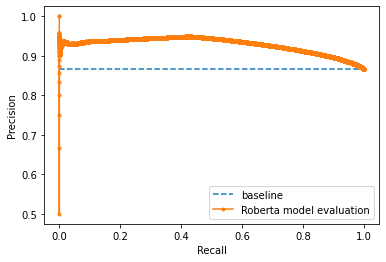

  Validation Loss: 0.46
  Validation took: 0:14:17

======== Epoch 2 / 8 ========
Training...
  Batch    40  of  7,606.    Elapsed: 0:00:57.
  Batch    80  of  7,606.    Elapsed: 0:01:54.
  Batch   120  of  7,606.    Elapsed: 0:02:51.
  Batch   160  of  7,606.    Elapsed: 0:03:48.
  Batch   200  of  7,606.    Elapsed: 0:04:45.
  Batch   240  of  7,606.    Elapsed: 0:05:42.
  Batch   280  of  7,606.    Elapsed: 0:06:39.
  Batch   320  of  7,606.    Elapsed: 0:07:36.
  Batch   360  of  7,606.    Elapsed: 0:08:33.
  Batch   400  of  7,606.    Elapsed: 0:09:30.
  Batch   440  of  7,606.    Elapsed: 0:10:27.
  Batch   480  of  7,606.    Elapsed: 0:11:24.
  Batch   520  of  7,606.    Elapsed: 0:12:21.
  Batch   560  of  7,606.    Elapsed: 0:13:18.
  Batch   600  of  7,606.    Elapsed: 0:14:15.
  Batch   640  of  7,606.    Elapsed: 0:15:13.
  Batch   680  of  7,606.    Elapsed: 0:16:10.
  Batch   720  of  7,606.    Elapsed: 0:17:07.
  Batch   760  of  7,606.    Elapsed: 0:18:04.
  Batch   800

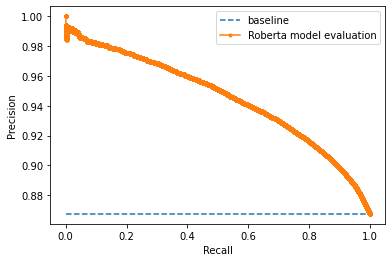

  Validation Loss: 0.76
  Validation took: 0:14:17

======== Epoch 3 / 8 ========
Training...
  Batch    40  of  7,606.    Elapsed: 0:00:57.
  Batch    80  of  7,606.    Elapsed: 0:01:54.
  Batch   120  of  7,606.    Elapsed: 0:02:51.
  Batch   160  of  7,606.    Elapsed: 0:03:48.
  Batch   200  of  7,606.    Elapsed: 0:04:45.
  Batch   240  of  7,606.    Elapsed: 0:05:42.
  Batch   280  of  7,606.    Elapsed: 0:06:39.
  Batch   320  of  7,606.    Elapsed: 0:07:36.
  Batch   360  of  7,606.    Elapsed: 0:08:33.
  Batch   400  of  7,606.    Elapsed: 0:09:30.
  Batch   440  of  7,606.    Elapsed: 0:10:27.
  Batch   480  of  7,606.    Elapsed: 0:11:24.
  Batch   520  of  7,606.    Elapsed: 0:12:21.
  Batch   560  of  7,606.    Elapsed: 0:13:18.
  Batch   600  of  7,606.    Elapsed: 0:14:15.
  Batch   640  of  7,606.    Elapsed: 0:15:12.
  Batch   680  of  7,606.    Elapsed: 0:16:09.
  Batch   720  of  7,606.    Elapsed: 0:17:06.
  Batch   760  of  7,606.    Elapsed: 0:18:03.
  Batch   800

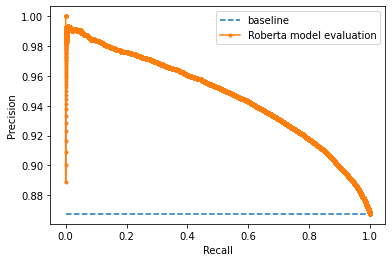

  Validation Loss: 0.68
  Validation took: 0:14:17

======== Epoch 4 / 8 ========
Training...
  Batch    40  of  7,606.    Elapsed: 0:00:57.
  Batch    80  of  7,606.    Elapsed: 0:01:54.
  Batch   120  of  7,606.    Elapsed: 0:02:51.
  Batch   160  of  7,606.    Elapsed: 0:03:48.
  Batch   200  of  7,606.    Elapsed: 0:04:45.
  Batch   240  of  7,606.    Elapsed: 0:05:42.
  Batch   280  of  7,606.    Elapsed: 0:06:39.
  Batch   320  of  7,606.    Elapsed: 0:07:36.
  Batch   360  of  7,606.    Elapsed: 0:08:33.
  Batch   400  of  7,606.    Elapsed: 0:09:30.
  Batch   440  of  7,606.    Elapsed: 0:10:27.
  Batch   480  of  7,606.    Elapsed: 0:11:24.
  Batch   520  of  7,606.    Elapsed: 0:12:21.
  Batch   560  of  7,606.    Elapsed: 0:13:18.
  Batch   600  of  7,606.    Elapsed: 0:14:15.
  Batch   640  of  7,606.    Elapsed: 0:15:12.
  Batch   680  of  7,606.    Elapsed: 0:16:09.
  Batch   720  of  7,606.    Elapsed: 0:17:06.
  Batch   760  of  7,606.    Elapsed: 0:18:03.
  Batch   800

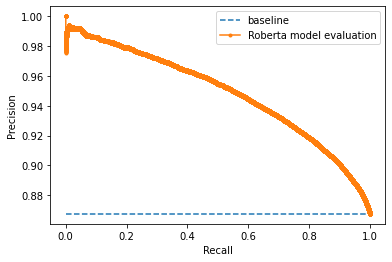

  Validation Loss: 0.55
  Validation took: 0:14:17

======== Epoch 5 / 8 ========
Training...
  Batch    40  of  7,606.    Elapsed: 0:00:57.
  Batch    80  of  7,606.    Elapsed: 0:01:54.
  Batch   120  of  7,606.    Elapsed: 0:02:51.
  Batch   160  of  7,606.    Elapsed: 0:03:48.
  Batch   200  of  7,606.    Elapsed: 0:04:45.
  Batch   240  of  7,606.    Elapsed: 0:05:42.
  Batch   280  of  7,606.    Elapsed: 0:06:39.
  Batch   320  of  7,606.    Elapsed: 0:07:36.
  Batch   360  of  7,606.    Elapsed: 0:08:33.
  Batch   400  of  7,606.    Elapsed: 0:09:30.
  Batch   440  of  7,606.    Elapsed: 0:10:27.
  Batch   480  of  7,606.    Elapsed: 0:11:24.
  Batch   520  of  7,606.    Elapsed: 0:12:21.
  Batch   560  of  7,606.    Elapsed: 0:13:18.
  Batch   600  of  7,606.    Elapsed: 0:14:15.
  Batch   640  of  7,606.    Elapsed: 0:15:12.
  Batch   680  of  7,606.    Elapsed: 0:16:09.
  Batch   720  of  7,606.    Elapsed: 0:17:06.
  Batch   760  of  7,606.    Elapsed: 0:18:03.
  Batch   800

In [ ]:
#Using class weight of cross entropy loss
from sklearn.metrics import classification_report,auc,confusion_matrix,f1_score,precision_recall_curve,plot_precision_recall_curve,matthews_corrcoef
import random
# This training code is based on the `run_glue.py` script here:
# https://github.com/huggingface/transformers/blob/5bfcd0485ece086ebcbed2d008813037968a9e58/examples/run_glue.py#L128

# Set the seed value all over the place to make this reproducible.
seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)
scaler = GradScaler()
criterion = torch.nn.BCEWithLogitsLoss()
# We'll store a number of quantities such as training and validation loss, 
# validation accuracy, and timings.
training_stats = []

# Measure the total training time for the whole run.
total_t0 = time.time()

# For each epoch...
for epoch_i in range(0, epochs):
    
    # ========================================
    #               Training
    # ========================================
    
    # Perform one full pass over the training set.

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    # Measure how long the training epoch takes.
    t0 = time.time()

    # Reset the total loss for this epoch.
    total_train_loss = 0

    # Put the model into training mode. Don't be mislead--the call to 
    # `train` just changes the *mode*, it doesn't *perform* the training.
    # `dropout` and `batchnorm` layers behave differently during training
    # vs. test (source: https://stackoverflow.com/questions/51433378/what-does-model-train-do-in-pytorch)
    roberta_model.train()

    # For each batch of training data...
    for step, batch in enumerate(train_dataloader):

        # Progress update every 40 batches.
        if step % 40 == 0 and not step == 0:
            # Calculate elapsed time in minutes.
            elapsed = format_time(time.time() - t0)
            
            # Report progress.
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        # Unpack this training batch from our dataloader. 
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using the 
        # `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        # Always clear any previously calculated gradients before performing a
        # backward pass. PyTorch doesn't do this automatically because 
        # accumulating the gradients is "convenient while training RNNs". 
        # (source: https://stackoverflow.com/questions/48001598/why-do-we-need-to-call-zero-grad-in-pytorch)
        roberta_model.zero_grad()        

        # Perform a forward pass (evaluate the model on this training batch).
        # The documentation for this `model` function is here: 
        # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
        # It returns different numbers of parameters depending on what arguments
        # arge given and what flags are set. For our useage here, it returns
        # the loss (because we provided labels) and the "logits"--the model
        # outputs prior to activation.
        with autocast():
            loss, logits = roberta_model(b_input_ids, 
                             token_type_ids=None, 
                             attention_mask=b_input_mask, 
                             labels=b_labels)
            b_labels1=torch.nn.functional.one_hot(b_labels, num_classes=2)
            #Calculating weights
            #positive=torch.sum(b_labels1, dim=0)
           # negative=len(b_labels1)-positive
            #negative
            #pos_weight  = positive / negative
            #criterion.pos_weight = pos_weight
            loss1 = cross_entropy(logits,b_labels).to(device)
           # print("loss:",loss1)
            loss1 = loss1 / gradient_accumulations

        # Accumulate the training loss over all of the batches so that we can
        # calculate the average loss at the end. `loss` is a Tensor containing a
        # single value; the `.item()` function just returns the Python value 
        # from the tensor.
        total_train_loss += loss1.item()

        # Perform a backward pass to calculate the gradients.
        scaler.scale(loss1).backward()

        # Clip the norm of the gradients to 1.0.
        # This is to help prevent the "exploding gradients" problem.
       # torch.nn.utils.clip_grad_norm_(model.parameters(),max_norm*scaler.get_scale())

        # Update parameters and take a step using the computed gradient.
        # The optimizer dictates the "update rule"--how the parameters are
        # modified based on their gradients, the learning rate, etc.
        if ((step + 1) % gradient_accumulations == 0):
             scaler.step(optimizer)
       # Updates the scale for next iteration.
             scaler.update()
        # Update the learning rate.
             scheduler.step()       
             optimizer.zero_grad()
            # roberta_model.zero_grad()

    # Calculate the average loss over all of the batches.
    avg_train_loss = total_train_loss / len(train_dataloader)            
    
    # Measure how long this epoch took.
    training_time = format_time(time.time() - t0)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epcoh took: {:}".format(training_time))
        
    # ========================================
    #               Validation
    # ========================================
    # After the completion of each training epoch, measure our performance on
    # our validation set.

    print("")
    print("Running Validation...")

    t0 = time.time()

    # Put the model in evaluation mode--the dropout layers behave differently
    # during evaluation.
    roberta_model.eval()

    # Tracking variables 
    total_eval_accuracy = 0
    total_eval_loss = 0
    nb_eval_steps = 0
    total_f1_score =0
    predlist=[]
    lbllist=[]
    total_logits=[]
    # Evaluate data for one epoch
    for batch in validation_dataloader:
        
        # Unpack this training batch from our dataloader. 
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using 
        # the `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        
        # Tell pytorch not to bother with constructing the compute graph during
        # the forward pass, since this is only needed for backprop (training).
        with torch.no_grad():        

            # Forward pass, calculate logit predictions.
            # token_type_ids is the same as the "segment ids", which 
            # differentiates sentence 1 and 2 in 2-sentence tasks.
            # The documentation for this `model` function is here: 
            # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
            # Get the "logits" output by the model. The "logits" are the output
            # values prior to applying an activation function like the softmax.
            (loss, logits) = roberta_model(b_input_ids, 
                                   token_type_ids=None, 
                                   attention_mask=b_input_mask,
                                   labels=b_labels)
            #Converting the labels to one hot to sync with same shape as logits
            b_labels1=torch.nn.functional.one_hot(b_labels, num_classes=2)
            loss1 = cross_entropy1(logits, b_labels)
       # print("loss1:",loss1)
            
        # Accumulate the validation loss.
        total_eval_loss += loss1.item()

         #Converting for predictions by applying sigmoid to logits
        pred_logits_sigmoid=torch.sigmoid(logits)
        y_pred=torch.round(pred_logits_sigmoid)

        # Move logits and labels to CPU
        logits_pred = y_pred.detach().cpu().numpy()
        label_ids1 = b_labels.to('cpu').numpy()
        logits=logits.detach().cpu().numpy()
        #For confusion matrix and classification report to work we need same dimensions.
        label_ids = b_labels1.to('cpu').numpy()
        pred_logits_sigmoid = pred_logits_sigmoid.detach().cpu().numpy()

        # Calculate the accuracy for this batch of test sentences, and
        # accumulate it over all batches.
        total_eval_accuracy += flat_accuracy(logits, label_ids1)

         #print(predictions)
        predictions=np.argmax(logits_pred, axis=1)
        y_test=np.argmax(label_ids,axis=1)
        predlist.extend(predictions)
        lbllist.extend(y_test)
        #Accumulating the sigmoid positive logits for precision recall curve
        total_logits.extend(pred_logits_sigmoid[:,1])
        total_f1_score += f1_score(predictions,y_test, average = 'macro')
        

    # Report the final accuracy for this validation run.
    avg_val_accuracy = total_eval_accuracy / len(validation_dataloader)
    print("  Accuracy: {0:.2f}".format(avg_val_accuracy))

    #f1 score

    avg_f1_score =total_f1_score/len(validation_dataloader)
    print("  F1 score: {0:.2f}".format(avg_f1_score))

     #classification report
    print(classification_report(lbllist, predlist))  

    #confusion matrix
    cm = confusion_matrix(lbllist,predlist)
    # constant for classes
    print(cm)
    #mcc score
    print("Mathews Correlation coefficient score for this epoch is :",round(matthews_corrcoef(lbllist, predlist),2))
    #Precision recall curve plot
    lr_precision, lr_recall, thresholds = precision_recall_curve(lbllist,total_logits)
    lr_f1, lr_auc = f1_score( lbllist,predlist), auc(lr_recall, lr_precision)
    print('Model validation score: f1=%.3f auc=%.3f' % (lr_f1, lr_auc))
    baseline = lbllist.count(1) / len(lbllist)
    plt.plot([0, 1], [baseline, baseline], linestyle='--', label='baseline')
    plt.plot(lr_recall, lr_precision, marker='.', label='Roberta model evaluation')
    # axis labels
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    # show the legend
    plt.legend()
    # show the plot
    plt.show()

    # Calculate the average loss over all of the batches.
    avg_val_loss = total_eval_loss / len(validation_dataloader)
    
    # Measure how long the validation run took.
    validation_time = format_time(time.time() - t0)
    
    print("  Validation Loss: {0:.2f}".format(avg_val_loss))
    print("  Validation took: {:}".format(validation_time))

    # Record all statistics from this epoch.
    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Valid. Accur.': avg_val_accuracy,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )

print("")
print("Training complete!")

print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))

In [ ]:
predlist=[]
predlist.extend(predictions)
predlist
#predlist.(predictions)

[0,
 0,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 1,
 1]

In [ ]:

pred=[]
label =[]
label.append(y_test)
#label = [a.squeeze().tolist() for a in label]
label1=np.argmax(label,axis=1)
pred.append(predictions)
#pred = [a.squeeze().tolist() for a in pred]
pred=np.argmax(pred,axis=1)
confusion_matrix(label1, pred)

array([[0, 1],
       [0, 0]])

In [ ]:
del roberta_model
del optimizer
del scheduler
torch.cuda.empty_cache()


XLNET

In [ ]:
from transformers import XLNetConfig,AutoConfig

configuration = XLNetConfig.from_pretrained('xlnet-base-cased',output_attentions=False,output_hidden_states=False,num_labels=2)
configuration.hidden_dropout_prob = 0.2
configuration.attention_probs_dropout_prob = 0.2

In [ ]:
#XLNET
xlnet_model = XLNetForSequenceClassification.from_pretrained("xlnet-base-cased", # 12-layer, 768-hidden, 12-heads, 125M parameters RoBERTa using the BERT-base architecture
                                                                   # num_labels = 2, # The number of output labels--2 for binary classification.
                                                                                    # You can increase this for multi-class tasks.   
                                                                   # output_attentions = False, # Whether the model returns attentions weights.
                                                                  #  output_hidden_states = False # Whether the model returns all hidden-states.
                                                              config =configuration
                                                                )
xlnet_tokenizer = XLNetTokenizer.from_pretrained("xlnet-base-cased")
# Tell pytorch to run this model on the GPU.
xlnet_model.cuda()


print(' Base model s loaded')

- This IS expected if you are initializing XLNetForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing XLNetForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


 Base model s loaded


In [ ]:

# Print the text split into tokens.
print('Tokenized XLNET: ', xlnet_tokenizer.tokenize(sentences[0]))

# Print the text mapped to token ids.
print('Token IDs XLNET: ', xlnet_tokenizer.convert_tokens_to_ids(roberta_tokenizer.tokenize(sentences[0])))

Tokenized XLNET:  ['▁drinks', '▁were', '▁bad', '▁', ',', '▁the', '▁hot', '▁chocolate', '▁was', '▁water', 'ed', '▁down', '▁and', '▁the', '▁la', 'tte', '▁had', '▁a', '▁burnt', '▁taste', '▁to', '▁it', '▁', '.', '▁the', '▁food', '▁was', '▁also', '▁poor', '▁quality', '▁', ',', '▁but', '▁the', '▁service', '▁was', '▁the', '▁worst', '▁part', '▁', ',', '▁their', '▁', 'cashier', '▁was', '▁very', '▁rude', '▁', '.']
Token IDs XLNET:  [7841, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 775, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2151, 0, 0, 0, 0]


In [ ]:
sequence = """Will Your Hometown Be Taking In Obama’s Refugees? Here’s The List Of Cities Where They’re Being Transplanted 🏙️"""
print("""Will Your Hometown Be Taking In Obama’s Refugees? Here’s The List Of Cities Where They’re Being Transplanted 🏙️""")
xlnet_tokenized_sequence=xlnet_tokenizer.tokenize(sequence)
print("XLNET:",xlnet_tokenized_sequence)

Will Your Hometown Be Taking In Obama’s Refugees? Here’s The List Of Cities Where They’re Being Transplanted 🏙️
XLNET: ['▁Will', '▁Your', '▁Home', 'town', '▁Be', '▁Taking', '▁In', '▁Obama', '’', 's', '▁Refugees', '?', '▁Here', '’', 's', '▁The', '▁List', '▁Of', '▁Cities', '▁Where', '▁They', '’', 're', '▁Being', '▁Trans', 'plant', 'ed', '▁', '🏙️']


In [ ]:
xlnet_tokenizer.pad_token,xlnet_tokenizer.pad_token_id

('<pad>', 5)

In [ ]:
token_lens = []

for txt in sentences:
    tokens = xlnet_tokenizer.encode(txt,truncation=True, max_length=512)
    token_lens.append(len(tokens))

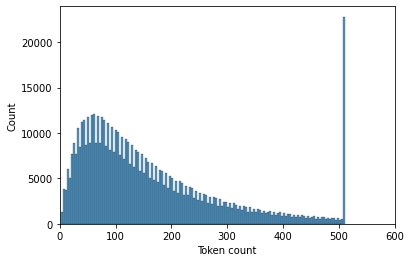

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.histplot(token_lens)
plt.xlim([0, 600]);
plt.xlabel('Token count');

In [ ]:
# Tokenize all of the sentences and map the tokens to thier word IDs.
xlnet_input_ids =[]
xlnet_attention_masks=[]
sentence_ids = []
counter = 0

# For every sentence...
for sent in sentences:
    # `encode_plus` will:
    #   (1) Tokenize the sentence.
    #   (2) Prepend the `[CLS]` token to the start.
    #   (3) Append the `[SEP]` token to the end.
    #   (4) Map tokens to their IDs.
    #   (5) Pad or truncate the sentence to `max_length`
    #   (6) Create attention masks for [PAD] tokens.
    xlnet_encoded_dict = xlnet_tokenizer.encode_plus(
                        sent,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        max_length = 260,           # Pad & truncate all sentences.
                        pad_to_max_length = True,
                        return_attention_mask = True,   # Construct attn. masks.
                        return_tensors = 'pt', 
                        truncation = True    # Return pytorch tensors.
                   )
    # Add the encoded sentence to the list.    
    xlnet_input_ids.append(xlnet_encoded_dict['input_ids'])
    
    # And its attention mask (simply differentiates padding from non-padding).
    xlnet_attention_masks.append(xlnet_encoded_dict['attention_mask'])
    
    # collecting sentence_ids
    sentence_ids.append(counter)
    counter  = counter + 1
    
    
    
# Convert the lists into tensors.

xlnet_input_ids = torch.cat(xlnet_input_ids, dim=0)
xlnet_attention_masks = torch.cat(xlnet_attention_masks, dim=0)
labels = torch.tensor(df_review_merge.label.values)

# Print sentence 0, now as a list of IDs.
print('Original: ', sentences[1])
print('Token IDs XLNET:', xlnet_input_ids[1])
print('labels:', labels)

Original:  this was the worst experience i ve ever had a casual coffee light fare place . the server disappeared for minutes , just talking to his friend by the window as my girlfriend and i sat dumbfounded that this dude had the nerve to do that on the job . we re trying to make eye contact , but clearly getting paid to talk to his bud was more important to him . my girlfriend went up to the counter once the server disappeared into the back for another minutes what is this guy doing ? and asked if she should order food up there or something . the girl at the counter gives her a weird look and just says i ll get your server . when they arrive from the back , they look over at our table and have a laugh . yeah , leaving us hanging for half a goddamn hour at a place with only two other customers is not funny but in retrospect , your collective incompetence and false sense of entitlement certainly was . the food was okay . for a place called toast , i d figured the bread would be better ,

In [ ]:
from torch.utils.data import TensorDataset, random_split
# function to seed the script globally
torch.manual_seed(1)
xlnet_dataset = TensorDataset(xlnet_input_ids, xlnet_attention_masks, labels)

In [ ]:
# Create a 80-20 train-validation split.

# Calculate the number of samples to include in each set.
train_size = int(0.8 * len(xlnet_dataset))
val_size = len(xlnet_dataset) - train_size

# Divide the dataset by randomly selecting samples.
train_dataset, val_dataset = random_split(xlnet_dataset, [train_size, val_size])

print('{:>5,} training samples'.format(train_size))
print('{:>5,} validation samples'.format(val_size))

486,766 training samples
121,692 validation samples


In [ ]:
len(train_dataset)

In [ ]:
import collections as c
train_classes = [df_review_merge.label[i] for i in train_dataset.indices]
c.Counter(train_classes)

Counter({1: 422366, 0: 64400})

In [ ]:
#Using weighted random sampler for class imbalance
import numpy as np 

y_train_indices = train_dataset.indices

y_train = [target[i] for i in y_train_indices]

class_sample_count = np.array(
    [len(np.where(y_train == t)[0]) for t in np.unique(y_train)])
print(class_sample_count)
weight = 1. / (class_sample_count)
print(weight)
samples_weight = np.array([weight[t] for t in y_train])
samples_weight = torch.from_numpy(samples_weight)
print(samples_weight)
sampler = torch.utils.data.sampler.WeightedRandomSampler(samples_weight.type('torch.DoubleTensor'), len(samples_weight))
print(next(iter(sampler)))
print(sampler)

[ 64400 422366]
[1.55279503e-05 2.36761482e-06]
tensor([2.3676e-06, 2.3676e-06, 2.3676e-06,  ..., 2.3676e-06, 2.3676e-06,
        2.3676e-06], dtype=torch.float64)
38322


In [ ]:
#Run if we are using weighted random sampler
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

# The DataLoader needs to know our batch size for training, so we specify it 
# here. For fine-tuning BERT on a specific task, the authors recommend a batch 
# size of 16 or 32 or 64.
batch_size = 32
gradient_accumulations=10

# Create the DataLoaders for our training and validation sets.
# We'll take training samples in random order. 
train_dataloader = DataLoader(
            train_dataset,  # The training samples.
            sampler = sampler, # Select batches randomly
            batch_size = batch_size, # Trains with this batch size.
            num_workers=2,
            pin_memory = True
        )

# For validation the order doesn't matter, so we'll just read them sequentially.
validation_dataloader = DataLoader(
            val_dataset, # The validation samples.
            sampler = SequentialSampler(val_dataset), # Pull out batches sequentially.
            batch_size = batch_size, # Evaluate with this batch size.
            num_workers =2,
            pin_memory = True
        )

In [ ]:
#Testing the label counts in training data after applying weighted random sampler
import collections as c
train_labels = next(iter(train_dataloader))
#print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels[0].values}")
#img = train_features[0].squeeze()
label = train_labels[2]
torch.bincount(label)
#print(label)


Labels batch shape: <built-in method values of Tensor object at 0x7febff2c9e90>


tensor([14, 18])

In [ ]:
len(train_dataloader)

15212

In [ ]:

# Get all of the model's parameters as a list of tuples.
params = list(xlnet_model.named_parameters())

print('The Xlnet model has {:} different named parameters.\n'.format(len(params)))

print('==== Embedding Layer ====\n')

for p in params[0:5]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== First Transformer ====\n')

for p in params[5:21]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== Output Layer ====\n')

for p in params[-4:]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

The Xlnet model has 210 different named parameters.

==== Embedding Layer ====

transformer.mask_emb                                     (1, 1, 768)
transformer.word_embedding.weight                       (32000, 768)
transformer.layer.0.rel_attn.q                          (768, 12, 64)
transformer.layer.0.rel_attn.k                          (768, 12, 64)
transformer.layer.0.rel_attn.v                          (768, 12, 64)

==== First Transformer ====

transformer.layer.0.rel_attn.o                          (768, 12, 64)
transformer.layer.0.rel_attn.r                          (768, 12, 64)
transformer.layer.0.rel_attn.r_r_bias                       (12, 64)
transformer.layer.0.rel_attn.r_s_bias                       (12, 64)
transformer.layer.0.rel_attn.r_w_bias                       (12, 64)
transformer.layer.0.rel_attn.seg_embed                   (2, 12, 64)
transformer.layer.0.rel_attn.layer_norm.weight                (768,)
transformer.layer.0.rel_attn.layer_norm.bias             

In [ ]:
# Note: AdamW is a class from the huggingface library (as opposed to pytorch) 
# I believe the 'W' stands for 'Weight Decay fix"
no_decay = ['bias', 'LayerNorm.weight']
optimizer_grouped_parameters = [
    {'params': [p for n, p in xlnet_model.named_parameters() if not any(nd in n for nd in no_decay)], 'weight_decay': 0.01},
    {'params': [p for n, p in xlnet_model.named_parameters() if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}
]
optimizer = AdamW(optimizer_grouped_parameters, lr=3e-5, eps = 1e-8)

In [ ]:
from transformers import get_linear_schedule_with_warmup

# Number of training epochs. The BERT authors recommend between 2 and 4. 
# We chose to run for 4, but we'll see later that this may be over-fitting the
# training data.
epochs = 1

# Total number of training steps is [number of batches] x [number of epochs]. 
# (Note that this is not the same as the number of training samples).
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)


======== Epoch 1 / 1 ========
Training...
  Batch    40  of  15,212.    Elapsed: 0:00:53.
  Batch    80  of  15,212.    Elapsed: 0:01:45.
  Batch   120  of  15,212.    Elapsed: 0:02:37.
  Batch   160  of  15,212.    Elapsed: 0:03:28.
  Batch   200  of  15,212.    Elapsed: 0:04:20.
  Batch   240  of  15,212.    Elapsed: 0:05:12.
  Batch   280  of  15,212.    Elapsed: 0:06:04.
  Batch   320  of  15,212.    Elapsed: 0:06:56.
  Batch   360  of  15,212.    Elapsed: 0:07:47.
  Batch   400  of  15,212.    Elapsed: 0:08:39.
  Batch   440  of  15,212.    Elapsed: 0:09:31.
  Batch   480  of  15,212.    Elapsed: 0:10:23.
  Batch   520  of  15,212.    Elapsed: 0:11:15.
  Batch   560  of  15,212.    Elapsed: 0:12:06.
  Batch   600  of  15,212.    Elapsed: 0:12:58.
  Batch   640  of  15,212.    Elapsed: 0:13:50.
  Batch   680  of  15,212.    Elapsed: 0:14:42.
  Batch   720  of  15,212.    Elapsed: 0:15:34.
  Batch   760  of  15,212.    Elapsed: 0:16:25.
  Batch   800  of  15,212.    Elapsed: 0:17:1

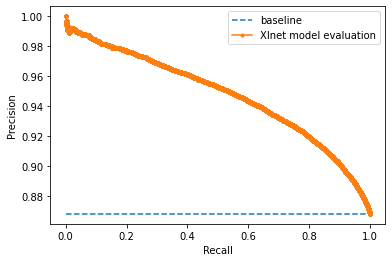

  Validation Loss: 0.55
  Validation took: 1:20:00

Training complete!
Total training took 6:48:16 (h:mm:ss)


In [ ]:
#using weighted random sampler
from sklearn.metrics import classification_report,auc,confusion_matrix,f1_score,precision_recall_curve,plot_precision_recall_curve,matthews_corrcoef
import random
# This training code is based on the `run_glue.py` script here:
# https://github.com/huggingface/transformers/blob/5bfcd0485ece086ebcbed2d008813037968a9e58/examples/run_glue.py#L128

# Set the seed value all over the place to make this reproducible.
seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)
scaler = GradScaler()
criterion = torch.nn.BCEWithLogitsLoss()
# We'll store a number of quantities such as training and validation loss, 
# validation accuracy, and timings.
training_stats = []

# Measure the total training time for the whole run.
total_t0 = time.time()

# For each epoch...
for epoch_i in range(0, epochs):
    
    # ========================================
    #               Training
    # ========================================
    
    # Perform one full pass over the training set.

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    # Measure how long the training epoch takes.
    t0 = time.time()

    # Reset the total loss for this epoch.
    total_train_loss = 0

    # Put the model into training mode. Don't be mislead--the call to 
    # `train` just changes the *mode*, it doesn't *perform* the training.
    # `dropout` and `batchnorm` layers behave differently during training
    # vs. test (source: https://stackoverflow.com/questions/51433378/what-does-model-train-do-in-pytorch)
    xlnet_model.train()

    # For each batch of training data...
    for step, batch in enumerate(train_dataloader):

        # Progress update every 40 batches.
        if step % 40 == 0 and not step == 0:
            # Calculate elapsed time in minutes.
            elapsed = format_time(time.time() - t0)
            
            # Report progress.
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        # Unpack this training batch from our dataloader. 
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using the 
        # `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        # Always clear any previously calculated gradients before performing a
        # backward pass. PyTorch doesn't do this automatically because 
        # accumulating the gradients is "convenient while training RNNs". 
        # (source: https://stackoverflow.com/questions/48001598/why-do-we-need-to-call-zero-grad-in-pytorch)
        xlnet_model.zero_grad()        

        # Perform a forward pass (evaluate the model on this training batch).
        # The documentation for this `model` function is here: 
        # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
        # It returns different numbers of parameters depending on what arguments
        # arge given and what flags are set. For our useage here, it returns
        # the loss (because we provided labels) and the "logits"--the model
        # outputs prior to activation.
        with autocast():
            loss, logits = xlnet_model(b_input_ids, 
                             token_type_ids=None, 
                             attention_mask=b_input_mask, 
                             labels=b_labels)
            b_labels1=torch.nn.functional.one_hot(b_labels, num_classes=2)
            #Calculating weights
            #positive=torch.sum(b_labels1, dim=0)
           # negative=len(b_labels1)-positive
            #negative
            #pos_weight  = positive / negative
            #criterion.pos_weight = pos_weight
            loss1 = loss_fn(logits,b_labels1).to(device)
           # print("loss:",loss1)
            loss1 = loss1 / gradient_accumulations

        # Accumulate the training loss over all of the batches so that we can
        # calculate the average loss at the end. `loss` is a Tensor containing a
        # single value; the `.item()` function just returns the Python value 
        # from the tensor.
        total_train_loss += loss1.item()

        # Perform a backward pass to calculate the gradients.
        scaler.scale(loss1).backward()

        # Clip the norm of the gradients to 1.0.
        # This is to help prevent the "exploding gradients" problem.
       # torch.nn.utils.clip_grad_norm_(model.parameters(),max_norm*scaler.get_scale())

        # Update parameters and take a step using the computed gradient.
        # The optimizer dictates the "update rule"--how the parameters are
        # modified based on their gradients, the learning rate, etc.
        if ((step + 1) % gradient_accumulations == 0):
             scaler.step(optimizer)
       # Updates the scale for next iteration.
             scaler.update()
        # Update the learning rate.
             scheduler.step()       
             optimizer.zero_grad()
            # xlnet_model.zero_grad()

    # Calculate the average loss over all of the batches.
    avg_train_loss = total_train_loss / len(train_dataloader)            
    
    # Measure how long this epoch took.
    training_time = format_time(time.time() - t0)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epcoh took: {:}".format(training_time))
        
    # ========================================
    #               Validation
    # ========================================
    # After the completion of each training epoch, measure our performance on
    # our validation set.

    print("")
    print("Running Validation...")

    t0 = time.time()

    # Put the model in evaluation mode--the dropout layers behave differently
    # during evaluation.
    xlnet_model.eval()

    # Tracking variables 
    total_eval_accuracy = 0
    total_eval_loss = 0
    nb_eval_steps = 0
    total_f1_score =0
    predlist =[]
    lbllist =[]
    total_logits=[]

    # Evaluate data for one epoch
    for batch in validation_dataloader:
        
        # Unpack this training batch from our dataloader. 
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using 
        # the `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        
        # Tell pytorch not to bother with constructing the compute graph during
        # the forward pass, since this is only needed for backprop (training).
        with torch.no_grad():        

            # Forward pass, calculate logit predictions.
            # token_type_ids is the same as the "segment ids", which 
            # differentiates sentence 1 and 2 in 2-sentence tasks.
            # The documentation for this `model` function is here: 
            # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
            # Get the "logits" output by the model. The "logits" are the output
            # values prior to applying an activation function like the softmax.
            (loss, logits) = xlnet_model(b_input_ids, 
                                   token_type_ids=None, 
                                   attention_mask=b_input_mask,
                                   labels=b_labels)
            #Converting the labels to one hot to sync with same shape as logits
            b_labels1=torch.nn.functional.one_hot(b_labels, num_classes=2)
            loss1 = loss_fn(logits, b_labels1)
       # print("loss1:",loss1)
            
        # Accumulate the validation loss.
        total_eval_loss += loss1.item()

         #Converting for predictions by applying sigmoid to logits
        pred_logits_sigmoid=torch.sigmoid(logits)
        y_pred=torch.round(pred_logits_sigmoid)
        
        # Move logits and labels to CPU
        logits_pred = y_pred.detach().cpu().numpy()
        label_ids1 = b_labels.to('cpu').numpy()
        logits=logits.detach().cpu().numpy()
        #For confusion matrix and classification report to work we need same dimensions.
        label_ids = b_labels1.to('cpu').numpy()
        pred_logits_sigmoid=pred_logits_sigmoid.detach().cpu().numpy()
     
        # Calculate the accuracy for this batch of test sentences, and
        # accumulate it over all batches.
        total_eval_accuracy += flat_accuracy(logits, label_ids1)

         #print(predictions)
       # predictions=np.argmax(logits_pred, axis=1)
        predictions =np.argmax(logits_pred,axis=1)
        y_test=np.argmax(label_ids,axis=1)
        predlist.extend(predictions)
        lbllist.extend(y_test)
        #Accumulating the sigmoid positive logits for precision recall curve
        total_logits.extend(pred_logits_sigmoid[:,1])
        #total_logits.extend(pred_logits_sigmoid)
        total_f1_score += f1_score(predlist,lbllist, average = 'macro')
        

    # Report the final accuracy for this validation run.
    avg_val_accuracy = total_eval_accuracy / len(validation_dataloader)
    print("  Accuracy: {0:.2f}".format(avg_val_accuracy))

    #f1 score

    avg_f1_score =total_f1_score/len(validation_dataloader)
    print("  F1 score: {0:.2f}".format(avg_f1_score))

     #classification report
    print(classification_report(lbllist, predlist))  

    #confusion matrix
    cm = confusion_matrix(lbllist,predlist)
    # constant for classes
    print(cm)
    #mcc score
    print("Mathews Correlation coefficient score for this epoch is :",round(matthews_corrcoef(lbllist, predlist),2))
    #Precision recall curve plot
    lr_precision, lr_recall, thresholds = precision_recall_curve(lbllist,total_logits)
    lr_f1, lr_auc = f1_score( lbllist,predlist), auc(lr_recall, lr_precision)
    print('Model validation score: f1=%.3f auc=%.3f' % (lr_f1, lr_auc))
    baseline = lbllist.count(1) / len(lbllist)
    plt.plot([0, 1], [baseline, baseline], linestyle='--', label='baseline')
    plt.plot(lr_recall, lr_precision, marker='.', label='Xlnet model evaluation')
    # axis labels
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    # show the legend
    plt.legend()
    # show the plot
    plt.show()

    # Calculate the average loss over all of the batches.
    avg_val_loss = total_eval_loss / len(validation_dataloader)
    
    # Measure how long the validation run took.
    validation_time = format_time(time.time() - t0)
    
    print("  Validation Loss: {0:.2f}".format(avg_val_loss))
    print("  Validation took: {:}".format(validation_time))

    # Record all statistics from this epoch.
    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Valid. Accur.': avg_val_accuracy,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )

print("")
print("Training complete!")

print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))

In [ ]:
del xlnet_model
del optimizer
del scheduler
torch.cuda.empty_cache()
